# 为什么对冲策略风险更大？

#
<!-- 市场方向性风险：如果对冲策略预测错误，如对冲的资产与主要投资资产的相关性突然改变，这可能导致预期外的损失。

杠杆效应：一些对冲策略通过使用杠杆来放大潜在收益，但同时也放大了潜在损失。

流动性风险：在极端市场条件下，某些对冲策略可能难以及时执行，特别是涉及到流动性较低的衍生品或资产。 -->





---
### 因子实战 第三集 
# 打造自己的对冲基金：用Python实现对冲策略

##### “我不知道未来会发生什么，但我知道我会在那里等着它” - 沃伦·巴菲特

### 🎬 @大导演哈罗德
### 🏛 香港中文大学 金融工程 本科
### 📈 即将前往美国金融工程硕士之路（已经获得录取）
### 🌐 [关注我的Bilibili，看所有人都能听得懂有收获的量化学习内容！](https://space.bilibili.com/629573485)

🌟🌟🌟 一起揭开量化的神秘面纱！#哈罗德的亮化频道🌟


---

读取数据

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

In [ ]:
df_mkt = pd.read_excel('Monthly_Market_Value_and_Return.xlsx', index_col=0)

In [6]:
df_mkt.reset_index(inplace=True)
df_mkt['stock'] = df_mkt['stock'].map(lambda x : str(x).zfill(6))
df_mkt

,index,stock,date,value_in_thousand,monthly_return,next_month_return
0,0,000001,2005-12,11947347.99,0.051370,0.034202
1,1,000001,2006-01,12355970.65,0.034202,0.077165
2,2,000001,2006-02,13309423.50,0.077165,-0.068713
3,3,000001,2006-03,12394887.09,-0.068713,0.237049
4,4,000001,2006-04,15333078.53,0.237049,0.114213
...,...,...,...,...,...,...
419256,419256,605599,2021-11,9636666.94,0.061697,0.086360
419257,419257,605599,2021-12,10468889.19,0.086360,-0.116642
419258,419258,605599,2022-01,9247778.04,-0.116642,0.105971
419259,419259,605599,2022-02,10227778.07,0.105971,-0.170342


In [7]:
df_mkt.drop(columns="index")

,stock,date,value_in_thousand,monthly_return,next_month_return
0,000001,2005-12,11947347.99,0.051370,0.034202
1,000001,2006-01,12355970.65,0.034202,0.077165
2,000001,2006-02,13309423.50,0.077165,-0.068713
3,000001,2006-03,12394887.09,-0.068713,0.237049
4,000001,2006-04,15333078.53,0.237049,0.114213
...,...,...,...,...,...
419256,605599,2021-11,9636666.94,0.061697,0.086360
419257,605599,2021-12,10468889.19,0.086360,-0.116642
419258,605599,2022-01,9247778.04,-0.116642,0.105971
419259,605599,2022-02,10227778.07,0.105971,-0.170342


In [9]:
df_mkt = df_mkt.drop(columns="index")

In [12]:
df = df_mkt
unique_dates = df['date'].unique()
unique_dates.sort()

---

先用一个简单的对冲方案，我们相信小市值的股票比大市值的具有投资价值，于是我们购买市场最小的1%的股票，看空市场最大的1%的股票，这样我们就构造了一个对冲组合。

这个组合的beta应该接近于0，也就是说这个组合的收益率应该与市场无关，那么我们就可以用这个组合来对冲掉市场的beta风险，从而获得一个alpha策略。

所以我们也叫这个策略为中性组合策略（market neutral strategy）或者对冲策略（hedged strategy）。

---

In [17]:
long_percentile = 1
short_percentile = 99

strategy_returns = []

for date in unique_dates:

    df_data = df[df['date'] == date]

    # print(df_data)

#              stock     date  value_in_thousand  monthly_return  next_month_return
# 0       000001  2005-12        11947347.99        0.051370           0.034202
# 194     000002  2005-12        13674033.12        0.091139           0.143852
# 384     000004  2005-12          347663.47       -0.077951           0.012077
# 571     000005  2005-12         1162204.56        0.064935           0.018293
# 751     000006  2005-12         1082836.27        0.038929           0.570960
# ...        ...      ...                ...             ...                ...
# 361104  600992  2005-12          685422.90        0.014599           0.071942
# 361300  600993  2005-12         1231143.94        0.024702          -0.081463
# 361496  600995  2005-12         1164681.00        0.037441           0.160902
# 361753  600997  2005-12         3357440.00        0.047184           0.192746
# 375495  601607  2005-12         1854554.98       -0.027363           0.046036

    long_threshold = np.percentile(df_data['value_in_thousand'], long_percentile)
    # print(long_threshold)
    short_threshold = np.percentile(df_data['value_in_thousand'], short_percentile)

    long_stock = df_data[  df_data["value_in_thousand"] <=     long_threshold ]['stock']
    short_stock = df_data[  df_data["value_in_thousand"] >=     short_threshold ]['stock']

    # print(long_stock)
    # print(short_stock)

    df_long_stocks = df_data[  df_data['stock'].isin(long_stock)       ]
    df_short_stocks = df_data[   df_data['stock'].isin(short_stock)            ]

#     print(df_long_stocks)
#              stock     date  value_in_thousand  monthly_return  next_month_return
# 12379   000156  2005-12          182385.00        0.010695          -0.190476
# 31107   000583  2005-12          217756.82       -0.121495           0.021277
# 37085   000622  2005-12          168672.98       -0.040323          -0.134454
# 52247   000736  2005-12          196020.00        0.042105          -0.080808
# 60395   000805  2005-12          141329.08       -0.117857          -0.024291
# 230198  600137  2005-12          187597.88        0.061856          -0.087379
# 246129  600234  2005-12          169886.60       -0.067010          -0.016575
# 254798  600286  2005-12          128820.00       -0.066116          -0.123894
# 270786  600385  2005-12          216225.18       -0.012903           0.019608
# 318194  600691  2005-12          181595.07        0.021739          -0.017021
# 330908  600762  2005-12          154269.44       -0.051948          -0.095890
# 338521  600807  2005-12          203982.02       -0.068966           0.116402
# 345613  600847  2005-12          199485.00        0.027397          -0.040000
# 353618  600892  2005-12          172710.00        0.030120           0.105263



    long_return = df_long_stocks['next_month_return'].mean()
    short_return = df_short_stocks['next_month_return'].mean()

    strategy_return = long_return - short_return
    strategy_returns.append(strategy_return)

    # break



In [18]:
strategy_returns

[-0.09524521428571431,
 0.05457492857142858,
 -0.05272485714285713,
 0.7668202857142858,
 3.304420428571428,
 0.09914300000000001,
 0.14556992857142853,
 -0.05050971428571429,
 0.1401067142857143,
 -0.11681578571428572,
 -0.2005852142857143,
 -0.3120871428571428,
 0.13585442857142854,
 0.528408642857143,
 0.16006707142857146,
 0.23726557142857144,
 0.5797239333333334,
 0.025465428571428583,
 0.13578407142857143,
 -0.08976871428571431,
 0.06962986666666668,
 -0.27316013333333333,
 0.24029133333333336,
 0.10551339999999995,
 0.15533486666666665,
 0.10936926666666669,
 0.03616193333333331,
 -0.1762028,
 0.10117320000000002,
 -0.05254433333333339,
 0.16705662499999996,
 -0.1316868125,
 -0.05666249999999999,
 0.04343281250000003,
 0.1910945,
 0.2081528125,
 0.1401535625,
 0.09861162499999998,
 0.18247887500000004,
 0.046863625000000006,
 0.05898450000000001,
 -0.017590124999999984,
 -0.036280249999999986,
 0.13852618749999995,
 -0.015284875000000003,
 0.0609863125,
 0.145520875,
 0.01564594

直观的图形

In [21]:
datetime

datetime.datetime

In [22]:
unique_dates_unchange = unique_dates.copy()
unique_dates = [   datetime.strptime(date, "%Y-%m")  for date in unique_dates   ]

/var/folders/md/wt8g61857ld_20f_r6rn4nk40000gn/T/ipykernel_25640/217182712.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


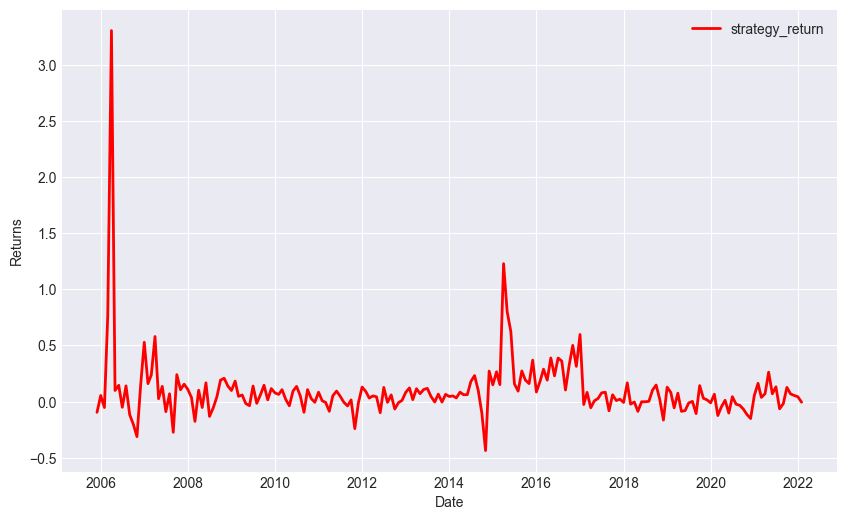

In [27]:
plt.style.use('seaborn-darkgrid')  
plt.figure(figsize=(10, 6))
plt.plot(unique_dates, strategy_returns, label= "strategy_return", color = "red", linewidth = 2)
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)

plt.show()




In [30]:
# strategy_returns al;ksdjfa;lksd
pd.DataFrame(strategy_returns,columns=['returns']).describe()

,returns
count,195.000000
mean,0.095424
std,0.293792
min,-0.436197
25%,-0.007169
50%,0.059759
75%,0.135594
max,3.304420


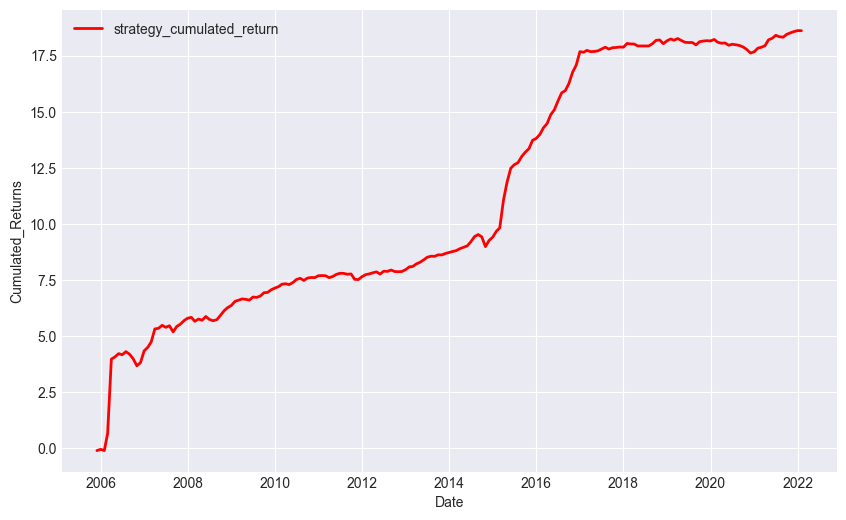

In [31]:
cumulated_returns = np.cumsum(strategy_returns)
plt.figure(figsize=(10, 6))
plt.plot(unique_dates, cumulated_returns, label= "strategy_cumulated_return", color = "red", linewidth = 2)
plt.xlabel("Date")
plt.ylabel("Cumulated_Returns")
plt.legend()
plt.grid(True)
plt.show()

这样是可以赚钱的
下一步？